In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.utils as utils
import torchvision.datasets as dsets
import torchvision.transforms as transforms

is_cuda = torch.cuda.is_available()
device = torch.device('cuda' if is_cuda else 'cpu')
print('Device : ', device)

Device :  cuda


In [5]:
# standardization code
standardizator = transforms.Compose([
                    transforms.ToTensor(),
                    transforms.Normalize(mean=(0.5),   # 3 for RGB channels이나 실제론 gray scale
                                         std=(0.5))])  # 3 for RGB channels이나 실제론 gray scale

In [6]:
# MNIST dataset
train_data = dsets.MNIST(root='data/', train=True, transform=standardizator, download=True)
test_data  = dsets.MNIST(root='data/', train=False, transform=standardizator, download=True)

In [7]:
batch_size = 200
train_data_loader = torch.utils.data.DataLoader(train_data, batch_size, shuffle=True, num_workers=8,pin_memory=True)
test_data_loader  = torch.utils.data.DataLoader(test_data, batch_size, shuffle=True, num_workers=8,pin_memory=True)

In [8]:
import numpy as np
from matplotlib import pyplot as plt

def imshow(img):
    img = (img+1)/2    
    img = img.squeeze()
    np_img = img.numpy()
    plt.imshow(np_img, cmap='gray')
    plt.show()

In [9]:
def imshow_grid(img): 
    img = utils.make_grid(img.cpu().detach())
    img = (img+1)/2
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.show()

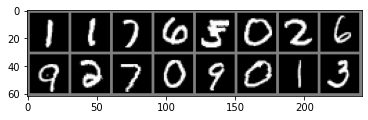

In [10]:
example_mini_batch_img, example_mini_batch_label  = next(iter(train_data_loader))
imshow_grid(example_mini_batch_img[0:16,:,:])

z :  tensor([[ 0.8285,  0.8830,  0.3804,  0.3344, -0.4137, -0.3535,  0.6057,  0.2845,
         -0.3015,  1.7846, -0.2924,  0.3559,  0.1528, -1.3364, -0.2283, -0.1303,
         -0.7606, -0.0873, -0.0157, -1.5380,  0.7060, -0.5370,  0.0413, -0.1873,
          0.3052,  0.7439,  2.1104,  0.3458,  0.7209, -0.9795, -0.0452, -0.3666,
          0.2754, -0.3467,  1.0427,  2.1804,  0.0514,  1.5542, -0.0952,  0.0357,
         -1.7667,  0.8795,  0.8953,  2.0491,  1.7118, -0.5730, -0.1495,  0.7974,
          0.3660,  0.0151, -0.7421,  1.0387,  0.4341, -0.2071, -0.2514,  0.6799,
         -1.3792,  1.1177,  0.4697,  1.0871, -0.2756,  1.3052, -0.2030,  0.5817,
          0.6599, -0.0395,  0.6645, -0.7306,  0.1722,  0.3432,  1.0352, -0.0536,
         -0.8777,  0.9060,  0.0243, -0.4776, -1.6251, -0.7990,  0.4472,  1.7184,
          1.0159,  0.3490,  0.8729,  0.4445,  0.0243,  0.9132,  0.0218,  0.3918,
         -1.1337, -1.0421, -1.2974,  0.1814, -0.6718,  0.3632,  0.3723, -1.2759,
         -1.0685,  1.12

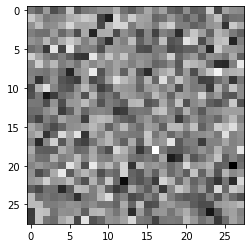

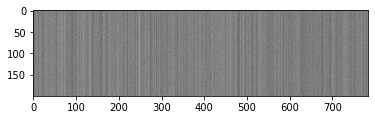

In [13]:
d_noise  = 100
d_hidden = 256

def sample_z(batch_size = 1, d_noise=100):
    return torch.randn(batch_size, d_noise, device=device)

G = nn.Sequential(
    nn.Linear(d_noise, d_hidden),
    nn.ReLU(),
    nn.Dropout(0.1),
    nn.Linear(d_hidden,d_hidden),
    nn.ReLU(),
    nn.Dropout(0.1),
    nn.Linear(d_hidden, 28*28),
    nn.Tanh()
).to(device)

# 노이즈 생성하기
z = sample_z()
print('z : ',z, '\nz shape : ',z.shape) 

# 가짜 이미지 생성하기
img_fake = G(z).view(-1,28,28)

# 이미지 출력하기
imshow(img_fake.squeeze().cpu().detach())

# Batch SIze만큼 노이즈 생성하여 그리드로 출력하기
z = sample_z(batch_size)
img_fake = G(z)
imshow_grid(img_fake)


In [14]:
D = nn.Sequential(
    nn.Linear(28*28, d_hidden),
    nn.LeakyReLU(),
    nn.Dropout(0.1),
    nn.Linear(d_hidden, d_hidden),
    nn.LeakyReLU(),
    nn.Dropout(0.1),
    nn.Linear(d_hidden, 1),
    nn.Sigmoid()
).to(device)


In [15]:
print(G(z).shape)
print(D(G(z)).shape)
print(D(G(z)[0:5]).transpose(0,1))

torch.Size([200, 784])
torch.Size([200, 1])
tensor([[0.4741, 0.4855, 0.4856, 0.4857, 0.4832]], device='cuda:0',
       grad_fn=<TransposeBackward0>)


In [16]:
# Loss Function
criterion = nn.BCELoss()

In [17]:
def run_epoch(generator, discriminator, _optimizer_g, _optimizer_d):
    
    generator.train()
    discriminator.train()

    for img_batch, label_batch in train_data_loader:
        
        img_batch, label_batch = img_batch.to(device), label_batch.to(device) 

        # ================================================  #
        # maximize V(discriminator,generator) = optimize discriminator (setting k to be 1)  #
        # ================================================  #

        # init optimizer
        _optimizer_d.zero_grad()

        p_real = discriminator(img_batch.view(-1, 28*28))
        p_fake = discriminator(generator(sample_z(batch_size, d_noise)))

        # ================================================  #
        #    Loss computation (soley based on the paper)    #
        # ================================================  #
        loss_real = -1 * torch.log(p_real)   # -1 for gradient ascending
        loss_fake = -1 * torch.log(1.-p_fake) # -1 for gradient ascending
        loss_d    = (loss_real + loss_fake).mean()
        
        # ================================================  #
        #     Loss computation (based on Cross Entropy)     #
        # ================================================  #
        # loss_d = criterion(p_real, torch.ones_like(p_real).to(device)) + \    #
        #          criterion(p_fake, torch.zeros_like(p_real).to(device))       #
        
        # Update parameters
        loss_d.backward()
        _optimizer_d.step()

        # ================================================  #
        #        minimize V(discriminator,generator)        #
        # ================================================  #

        # init optimizer
        _optimizer_g.zero_grad()

        p_fake = discriminator(generator(sample_z(batch_size, d_noise)))
                
        # ================================================  #
        #    Loss computation (soley based on the paper)    #
        # ================================================  #
        
        # instead of: torch.log(1.-p_fake).mean() <- explained in Section 3
        loss_g = -1 * torch.log(p_fake).mean() 

        # ================================================  #
        #     Loss computation (based on Cross Entropy)     #
        # ================================================  #
        # loss_g = criterion(p_fake, torch.ones_like(p_fake).to(device)) #

        loss_g.backward()
   
        # Update parameters
        _optimizer_g.step()

In [18]:
def evaluate_model(generator, discriminator):
    
    p_real, p_fake = 0.,0.
    
    generator.eval()
    discriminator.eval()
        
    for img_batch, label_batch in test_data_loader:
        
        img_batch, label_batch = img_batch.to(device), label_batch.to(device) 
        
        with torch.autograd.no_grad():
            p_real += (torch.sum(discriminator(img_batch.view(-1, 28*28))).item())/10000.
            p_fake += (torch.sum(discriminator(generator(sample_z(batch_size, d_noise)))).item())/10000.
            
            
    return p_real, p_fake

 24%|██▍       | 49/200 [03:59<11:41,  4.65s/it](epoch 50/200) p_real: 0.798681, p_g: 0.254100


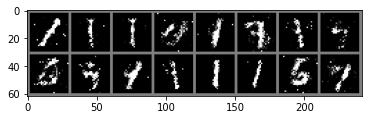

 50%|████▉     | 99/200 [07:55<08:29,  5.05s/it](epoch 100/200) p_real: 0.644470, p_g: 0.270092


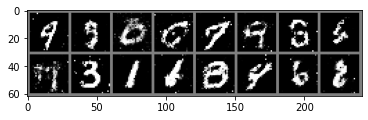

 74%|███████▍  | 149/200 [11:49<03:54,  4.60s/it](epoch 150/200) p_real: 0.611079, p_g: 0.252068


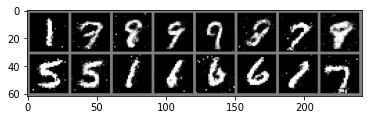

100%|█████████▉| 199/200 [15:42<00:04,  4.65s/it](epoch 200/200) p_real: 0.585052, p_g: 0.271267


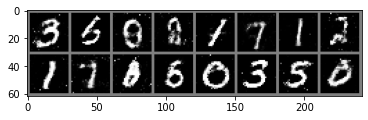

100%|██████████| 200/200 [15:47<00:00,  4.74s/it]


In [20]:
from tqdm import tqdm
def init_params(model):
    for p in model.parameters():
        if(p.dim() > 1):
            nn.init.xavier_normal_(p)
        else:
            nn.init.uniform_(p, 0.1, 0.2)

init_params(G)
init_params(D)

optimizer_g = optim.Adam(G.parameters(), lr = 0.0002)
optimizer_d = optim.Adam(D.parameters(), lr = 0.0002)

p_real_trace = []
p_fake_trace = []

for epoch in tqdm(range(200)):
    
    run_epoch(G, D, optimizer_g, optimizer_d)
    p_real, p_fake = evaluate_model(G,D)
    
    p_real_trace.append(p_real)
    p_fake_trace.append(p_fake) 
    
    if((epoch+1)% 50 == 0):
        print('(epoch %i/200) p_real: %f, p_g: %f' % (epoch+1, p_real, p_fake))
        imshow_grid(G(sample_z(16)).view(-1, 1, 28, 28))

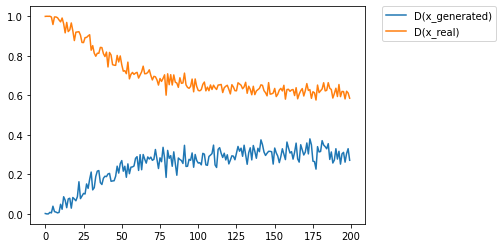

In [21]:
plt.plot(p_fake_trace, label='D(x_generated)')
plt.plot(p_real_trace, label='D(x_real)')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.show()

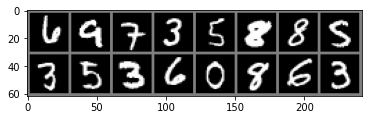

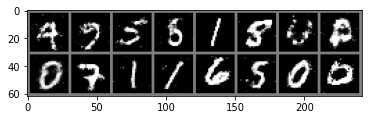

In [22]:
vis_loader = torch.utils.data.DataLoader(test_data, 16, True)
img_vis, label_vis   = next(iter(vis_loader))
imshow_grid(img_vis)

imshow_grid(G(sample_z(16,100)).view(-1, 1, 28, 28))